In [ ]:
#| default_exp fit

From https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html

In [ ]:
#| export
import lmfit

In [ ]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyndamics3 import Simulation

pyndamics3  version  0.0.29


In [ ]:
#| export
import numpy as np
from lmfit import minimize, Parameters, report_fit

In [ ]:
from scipy.integrate import odeint


In [ ]:
def f(xs, t, ps):
    """Receptor synthesis-internalization model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
    except:
        a, b = ps
    x = xs

    return a - b*x

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 10
    # variables        = 3
    chi-square         = 6.30791195
    reduced chi-square = 0.90113028
    Akaike info crit   = 1.39219617
    Bayesian info crit = 2.29995145
[[Variables]]
    x0:  11.7281014 +/- 0.94027396 (8.02%) (init = 11.93353)
    a:   3.87640476 +/- 1.51606470 (39.11%) (init = 1)
    b:   0.84816107 +/- 0.28470831 (33.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  = 0.982
    C(x0, b) = 0.340
    C(x0, a) = 0.307


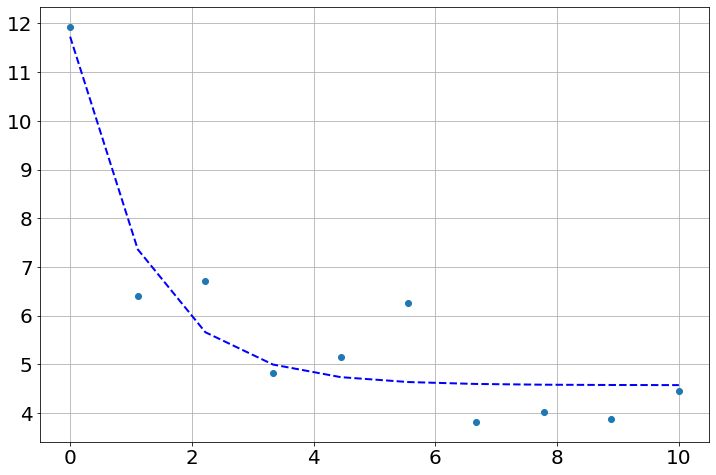

In [ ]:
a = 2.0
b = 0.5
true_params = [a, b]
x0 = 10.0


t = np.linspace(0, 10, 10)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value=float(data[0]), min=0, max=100)
params.add('a', value= 1.0, min=0, max=10)
params.add('b', value= 1.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plot(t, data, 'o')
plot(t, final, '--', linewidth=2, c='blue');

# display fitted statistics
report_fit(result)

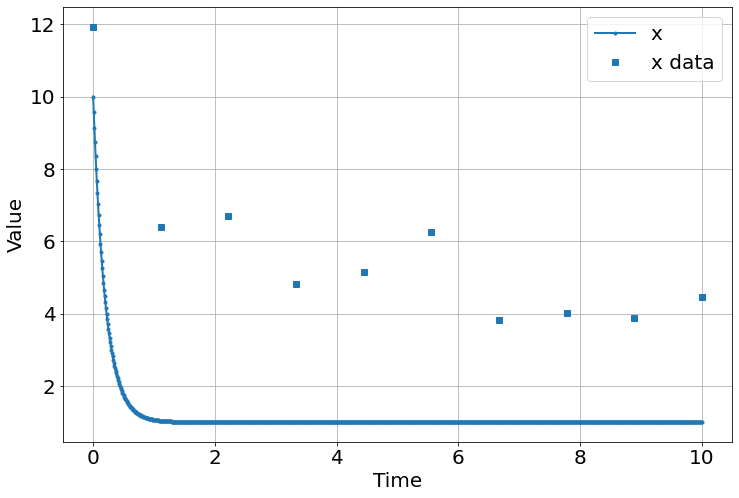

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("x'=a-b*x",10,plot=True)
sim.add_data(t=t,x=data,plot=True)
sim.params(a=5.,b=5)
sim.run(10)

In [ ]:
#| export
def Parameter(name,**kwargs):
    from lmfit import Parameters
    params = Parameters()
    params.add(name, **kwargs)
    
    return params

In [ ]:
#| export
def residual(ps, sim):
    
    params={}
    for key in ps.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            _c=sim.get_component(name)
            _c.initial_value=ps[key].value
            
        else:
            params[key]=ps[key].value
            
    sim.params(**params)
    
    # run the sim
    sim.run_fast()
    
    # compare with data
    values=[]
    for _c in sim.components+sim.assignments:
        if not _c.data:
            continue
        t=np.array(_c.data['t']).ravel()
        y=np.array(_c.data['value']).ravel()
        y_fit=sim.interpolate(t,_c.name)

        if any(np.isnan(y_fit)):
            values.append([-np.inf])
        elif any(abs(y_fit)>1e100):
            values.append([-np.inf])
        else:
            values.append(y-y_fit)

    return np.concatenate(values).ravel()
    

def fit(sim,
       *args,method='leastsq'):
    
    found_data=False
    for _c in sim.components+sim.assignments:
        if not _c.data:
            continue
        found_data=True
        
    if not found_data:
        raise ValueError("No data given for the simulation...can't fit.")
    
    
    
    from lmfit import Parameters,minimize
    
    fitparams=Parameters()
    for arg in args:
        fitparams+=arg
    
    for key in fitparams.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            try:
                _c=sim.get_component(name)
            except IndexError:
                raise ValueError("%s is a bad initial variable because %s is not a variable in the dynamical model." % (key,name))
        else:
            if not key in sim.original_params:
                raise ValueError("%s is not a parameter in the dynamical model.  Parameters are %s" % (key,str(sim.original_params)))

    
    result = minimize(residual, fitparams, args=(sim,), method=method)    
    
    params={}
    ps=result.params
    for key in ps.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            _c=sim.get_component(name)
            _c.initial_value=ps[key].value
            
        else:
            params[key]=ps[key].value
            
    sim.params(**params)
    
    
    return result


In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0),
   Parameter('b',value=5,min=0),
   Parameter('initial_x',value=10,min=0),
           method='nelder')

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 10
    # variables        = 3
    chi-square         = 6.22762490
    reduced chi-square = 0.88966070
    Akaike info crit   = 1.26409931
    Bayesian info crit = 2.17185459
[[Variables]]
    x0:  10.1696762 +/- 0.86311212 (8.49%) (init = 10.57152)
    a:   1.03472014 +/- 0.72827934 (70.38%) (init = 1)
    b:   0.30325336 +/- 0.13370646 (44.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  =  0.982
    C(x0, b) =  0.545
    C(x0, a) =  0.471


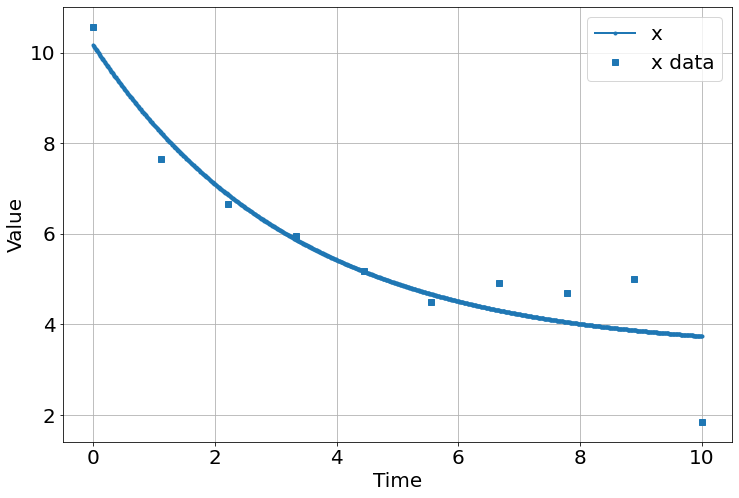

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(10)

In [ ]:
residual(result.params,sim)

array([ 0.40195727, -0.59547981, -0.20218646,  0.08638268,  0.0065436 ,
       -0.17139455,  0.59961184,  0.64913506,  1.12173166, -1.89591862])

In [ ]:
result

In [ ]:
a=result.params['a']

In [ ]:
a.stderr

0.7282793434890137

## Example with Growth

In [ ]:
t=array([7,14,21,28,35,42,49,56,63,70,77,84],float)
h=array([17.93,36.36,67.76,98.10,131,169.5,205.5,228.3,247.1,250.5,253.8,254.5])

### Linear Model

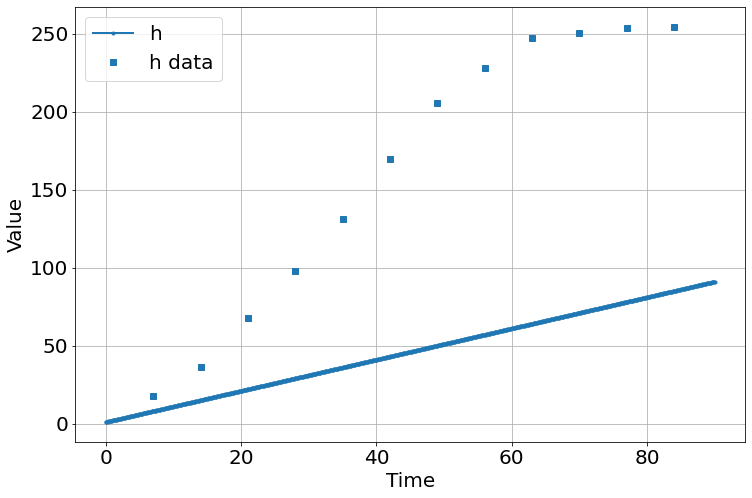

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("h'=a",1,plot=True)
sim.add_data(t=t,h=h,plot=True)
sim.params(a=1)
sim.run(0,90)

In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0),
   Parameter('initial_h',value=10,min=0))

results

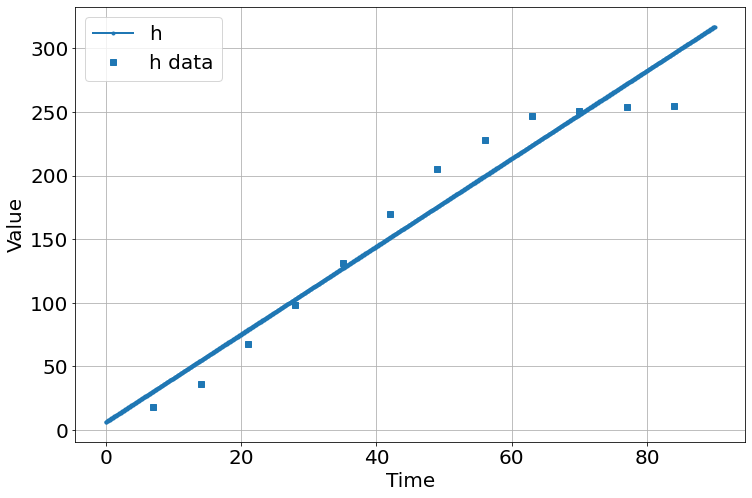

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(0,90)

### Logistic

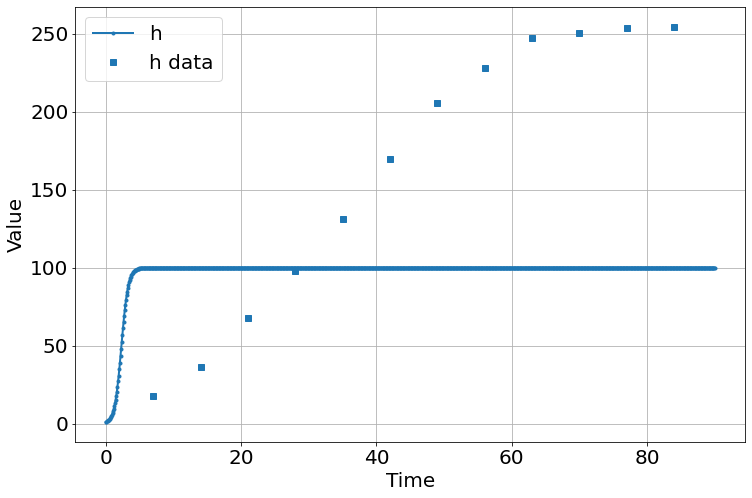

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("h'=a*h*(1-h/K)",1,plot=True)
sim.add_data(t=t,h=h,plot=True)
sim.params(a=2,K=100)
sim.run(0,90)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 12
    # variables        = 3
    chi-square         = 58540.1602
    reduced chi-square = 6504.46224
    Akaike info crit   = 107.910740
    Bayesian info crit = 109.365460
[[Variables]]
    a:          0.39591903 +/- 0.03501417 (8.84%) (init = 1)
    K:          150.029253 +/- 62.6057614 (41.73%) (init = 1)
    initial_h:  0.00122368 +/- 0.00128950 (105.38%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, initial_h) = -0.648
    C(a, K)         = -0.256
    C(K, initial_h) =  0.123


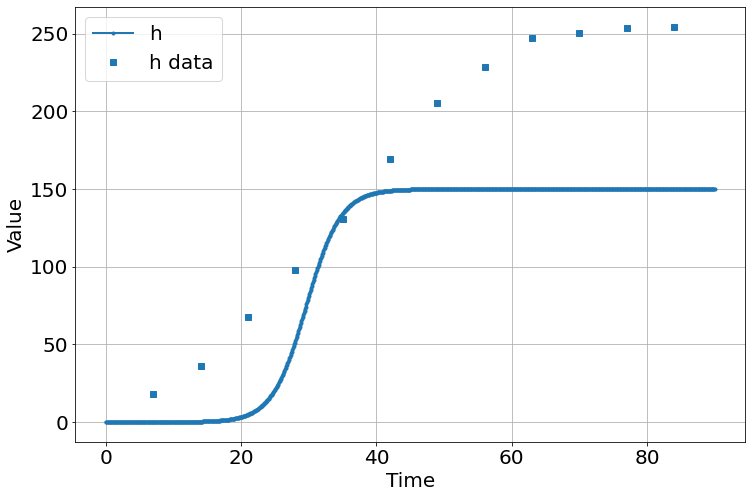

<Figure size 864x576 with 0 Axes>

In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0.01,max=2),
   Parameter('K',value=1,min=0,max=400),
   Parameter('initial_h',value=10,min=0,max=50))

report_fit(results)

sim.run(0,90)

the fit is lousy -- bad initial guesses, method possibly a problem.   Retrying with powell method.

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 700
    # data points      = 12
    # variables        = 3
    chi-square         = 127.063951
    reduced chi-square = 14.1182168
    Akaike info crit   = 34.3174063
    Bayesian info crit = 35.7721263
[[Variables]]
    a:          0.08770737 +/- 0.00291482 (3.32%) (init = 1)
    K:          261.039662 +/- 2.59358044 (0.99%) (init = 1)
    initial_h:  12.3091251 +/- 1.10573219 (8.98%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, initial_h) = -0.943
    C(a, K)         = -0.650
    C(K, initial_h) =  0.495


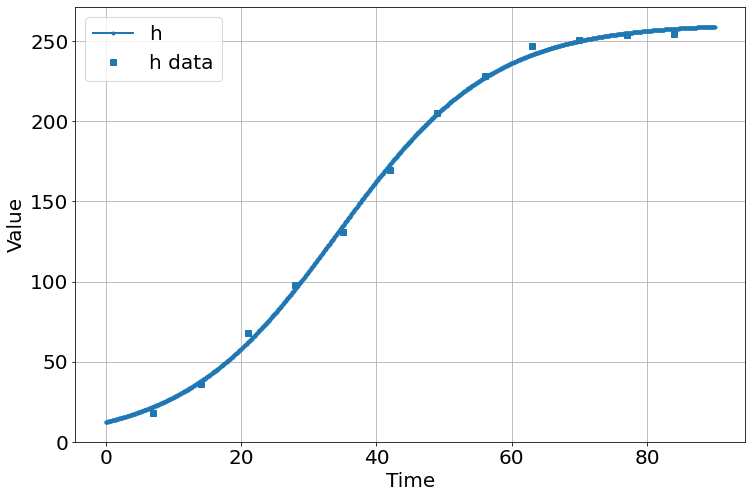

<Figure size 864x576 with 0 Axes>

In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0.01,max=2),
   Parameter('K',value=1,min=0,max=400),
   Parameter('initial_h',value=10,min=0,max=50),method='powell')

report_fit(results)

sim.run(0,90)

much better!